In [1]:
import numpy as np

from scipy.special import j1, struve

from AcousticProperties import *
from GmshBoundaries import *
from RayleighSolver import *
from SamplingPatterns import *
from Plots import *
%matplotlib inline

import gmsh
from joblib import Parallel, delayed


def magnitude(k, boundary_condition, samples):
    solution = solver.solve_boundary(k, boundary_condition)
    phi = solver.solve_samples(solution, samples)
    return sound_magnitude(sound_pressure(k, phi))

def theoretical_pressure(R, V, k, r, theta, rho=1.205, c=344.0):
    "From Morse & Ingard: Theoretical Acoustics"
    sin_theta = k * R * np.sin(theta)
    f_omega = 2.0 * V * np.pi * R**2 * (2.0 * j1(sin_theta) / sin_theta)
    return -1j * k * rho * c * np.exp(1j * k * r) / (4 * np.pi * r) * f_omega

def theoretical_magnitude(R, V, k, r, theta, rho = 1.205, c = 344.0):
    return sound_magnitude(theoretical_pressure(R, V, k, r, theta, rho, c))

def analytical_zm(r, wavenumbers, rho, c):
    "From Pierce: Acoustics"
    R1 = 1.0 - 2 * j1(2.0 * wavenumbers * r) / (2.0 * wavenumbers * r)
    X1 = 2 * struve(1, 2.0 * wavenumbers * r) / (2.0 * wavenumbers * r)
    Zm = density * c * np.pi * r**2 * (R1 - 1j * X1)
    return Zm

def numerical_zm(k, boundary_condition):
    solution = solver.solve_boundary(k, boundary_condition)
    return solution.mechanical_impedance()
 

V = 1.0 # piston velocity
c = 344.0
density = 1.205
max_edge = 0.03

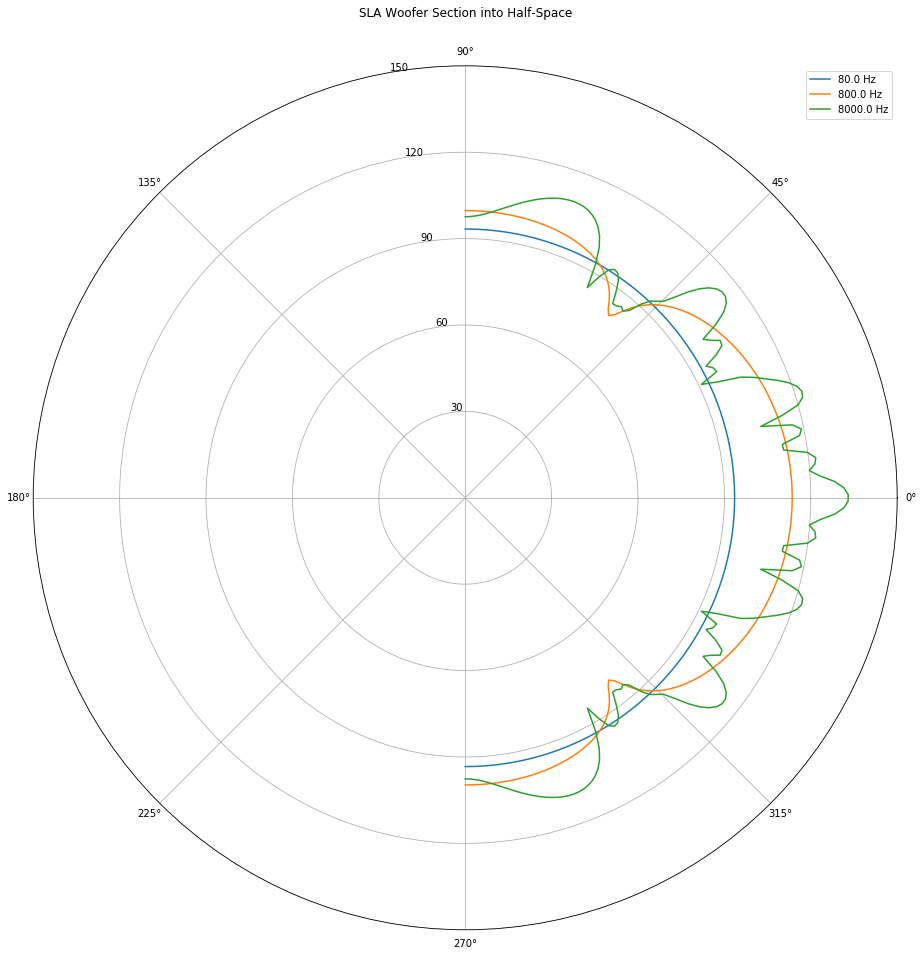

CPU times: user 611 ms, sys: 40.6 ms, total: 652 ms
Wall time: 3.98 s


In [2]:
%%time

frequencies = np.array([80, 800, 8000], dtype=np.float32)
wavenumbers = frequency_to_wavenumber(frequencies)

mesh  = woofers_sla(max_edge) # Fitzmaurice SLA woofer section
solver = RayleighSolver3D(mesh)
boundary_condition = solver.neumann_boundary_condition()
boundary_condition.f.fill(V)

samples, _, angles = semi_circle(5, 180, "yz")

magnitudes = Parallel(n_jobs=4)(delayed(magnitude)(k, boundary_condition, samples) for k in wavenumbers)

polar_plot("SLA Woofer Section into Half-Space", frequencies, angles, magnitudes)

CPU times: user 1.43 s, sys: 58.7 ms, total: 1.48 s
Wall time: 7min 45s


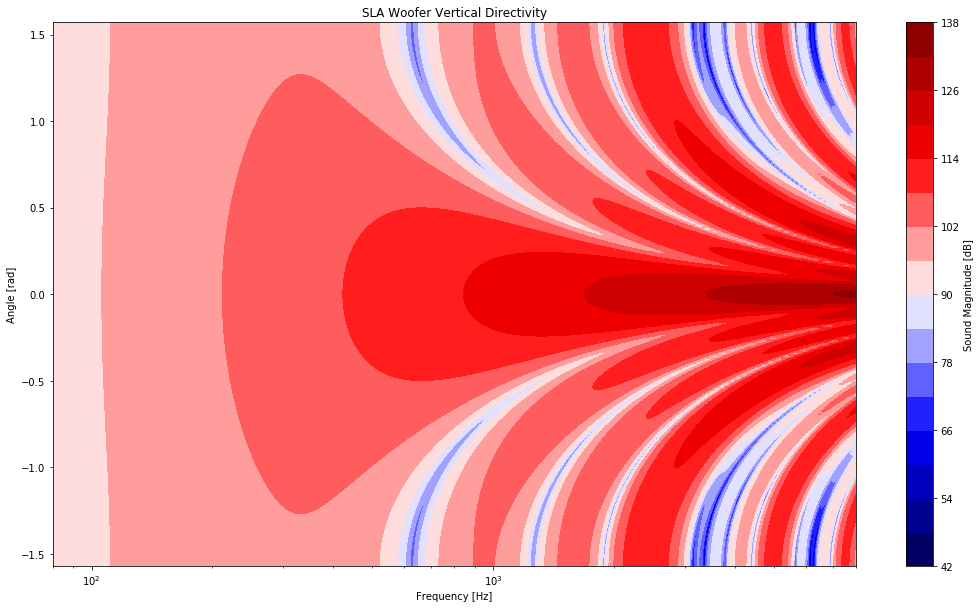

In [3]:
%%time
frequency_samples = 600
frequencies = np.logspace(np.log10(80), np.log10(8000), frequency_samples)
wavenumbers = frequency_to_wavenumber(frequencies)

angle_samples = 180
samples, _, angles = semi_circle(5, angle_samples, "yz")

magnitudes = Parallel(n_jobs=4)(delayed(magnitude)(k, boundary_condition, samples) for k in wavenumbers)
magnitudes = np.asarray(magnitudes).transpose()

plot_polar_map('SLA Woofer Vertical Directivity', frequencies, angles, magnitudes)

CPU times: user 1.44 s, sys: 35.1 ms, total: 1.47 s
Wall time: 8min 29s


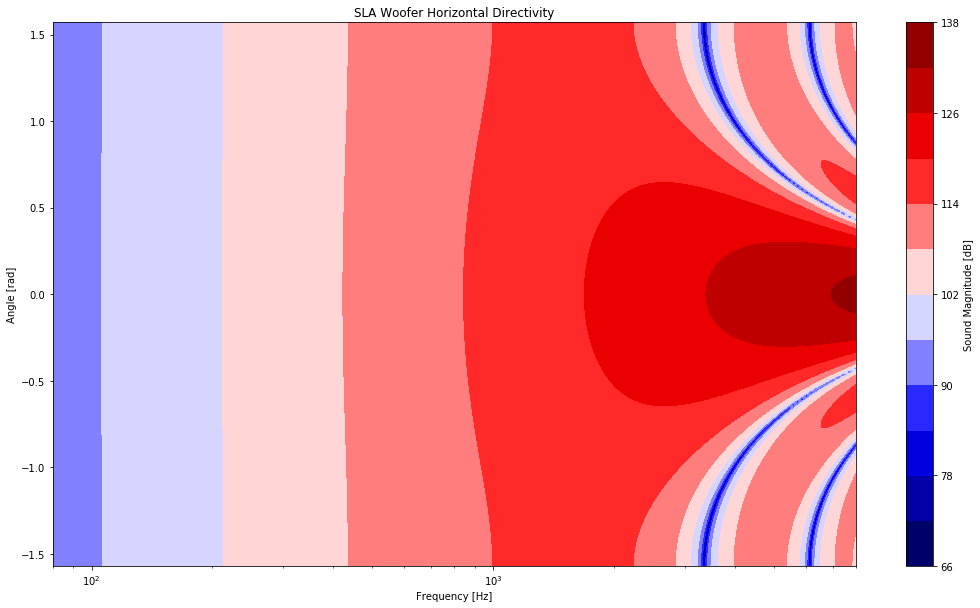

In [4]:
%%time
samples, _, angles = semi_circle(5, angle_samples, "xz")

magnitudes = Parallel(n_jobs=4)(delayed(magnitude)(k, boundary_condition, samples) for k in wavenumbers)
magnitudes = np.asarray(magnitudes).transpose()

plot_polar_map('SLA Woofer Horizontal Directivity', frequencies, angles, magnitudes)

CPU times: user 1.29 s, sys: 39.8 ms, total: 1.33 s
Wall time: 5min 23s


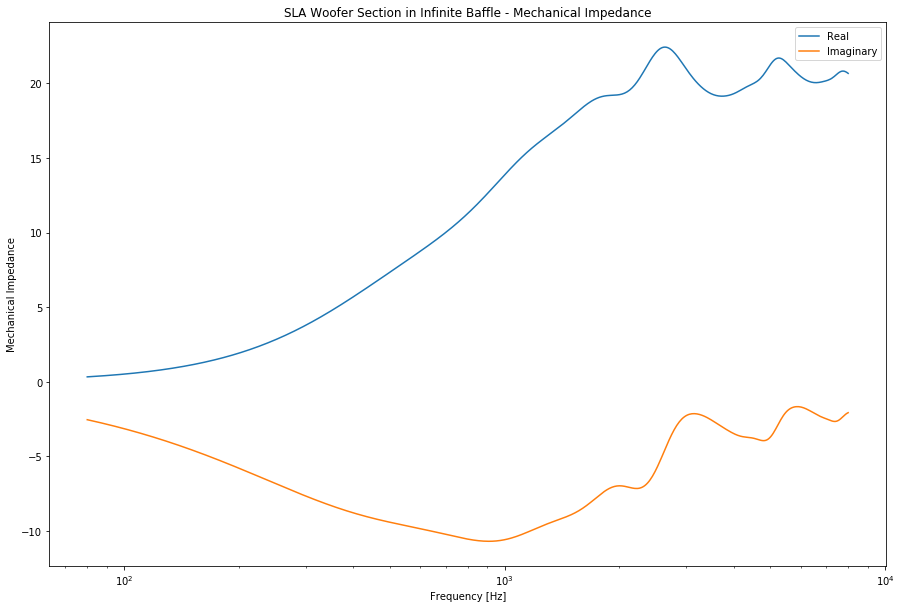

In [5]:
%%time
numerical_zm = Parallel(n_jobs=4)(delayed(numerical_zm)(k, boundary_condition) for k in wavenumbers)
numerical_zm = np.asarray(numerical_zm)

fig, ax = plt.subplots(figsize = (15, 10))
ax.set_title('SLA Woofer Section in Infinite Baffle - Mechanical Impedance')
ax.set_xlabel('Frequency [Hz]')
ax.set_xscale('log') 
ax.set_ylabel('Mechanical Impedance')
ax.plot(frequencies, np.real(numerical_zm), label='Real')
ax.plot(frequencies, np.imag(numerical_zm), label='Imaginary')
ax.legend()